In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/istanbul-airbnb-dataset/listings.csv


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/kaggle/input/istanbul-airbnb-dataset/listings.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,4826,The Place,6603,Kaan,NaN,Uskudar,41.05650,29.05367,Entire home/apt,720,1,1,2009-06-01,0.01,1,365
1,20815,The Bosphorus from The Comfy Hill,78838,Gülder,NaN,Besiktas,41.06984,29.04545,Entire home/apt,816,365,41,2018-11-07,0.33,2,279
2,27271,LOVELY APT. IN PERFECT LOCATION,117026,Mutlu,NaN,Beyoglu,41.03254,28.98153,Entire home/apt,233,30,13,2018-05-04,0.19,1,289
3,28277,Duplex Apartment with Terrace,121607,Alen,NaN,Sisli,41.04471,28.98567,Hotel room,761,3,0,NaN,NaN,19,365
4,28318,Cosy home overlooking Bosphorus,121721,Aydin,NaN,Sariyer,41.09048,29.05559,Entire home/apt,823,3,0,NaN,NaN,1,88


In [4]:
df = df[df['price'] != 0]


In [5]:
df = df.reset_index(drop=True)

In [6]:
df.isnull().sum()

id                                    0
name                                 54
host_id                               0
host_name                             1
neighbourhood_group               23725
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       12374
reviews_per_month                 12374
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
silinecek_sutunlar = ['name', 'host_name','last_review']
df = df.drop(silinecek_sutunlar, axis=1)

In [8]:
df.isnull().sum()

id                                    0
host_id                               0
neighbourhood_group               23725
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 12374
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
region = df.loc[:, 'neighbourhood_group']

#extracting unique values
unique_regions = pd.unique(region)
print('Distinct regions: ', unique_regions)

Distinct regions:  [nan]


In [10]:
#since this data has no major regions(neighbourhood groups), I decided to map out my own

asianorth_side = ['Sile', 'Beykoz', 'Cekmekoy']
asiasouth_side = ['Kadikoy', 'Uskudar', 'Atasehir', 'Maltepe', 'Umraniye', 'Sultanbeyli', 'Pendik', 'Kartal', 'Adalar', 'Tuzla', 'Sancaktepe']
europenorth_side = ['Sisli', 'Sariyer', 'Eyup', 'Sultangazi', 'Catalca', 'Arnavutkoy']
europesouth_side = ['Beyoglu', 'Besiktas', 'Fatih', 'Kagithane', 'Bakirkoy', 'Basaksehir', 'Bahcelievler', 'Avcilar', 'Bayrampasa', 'Esenler', 'Kucukcekmece', 'Bagcilar', 'Buyukcekmece', 'Beylikduzu', 'Zeytinburnu', 'Gaziosmanpasa', 'Gungoren', 'Silivri', 'Esenyurt']

#create the mapping
neighbourhood_to_group = {}
for neighbourhood in asianorth_side:
    neighbourhood_to_group[neighbourhood] = 'Asia North'
for neighbourhood in asiasouth_side:
    neighbourhood_to_group[neighbourhood] = 'Asia South'
for neighbourhood in europenorth_side:
    neighbourhood_to_group[neighbourhood] = 'Europe North'
for neighbourhood in europesouth_side:
    neighbourhood_to_group[neighbourhood] = 'Europe South'
    
#lets apply the mapping
df['neighbourhood_group'] = df['neighbourhood'].map(neighbourhood_to_group)
df.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,4826,6603,Asia South,Uskudar,41.05650,29.05367,Entire home/apt,720,1,1,0.01,1,365
1,20815,78838,Europe South,Besiktas,41.06984,29.04545,Entire home/apt,816,365,41,0.33,2,279
2,27271,117026,Europe South,Beyoglu,41.03254,28.98153,Entire home/apt,233,30,13,0.19,1,289
3,28277,121607,Europe North,Sisli,41.04471,28.98567,Hotel room,761,3,0,NaN,19,365
4,28318,121721,Europe North,Sariyer,41.09048,29.05559,Entire home/apt,823,3,0,NaN,1,88


In [11]:
ortalama = df['reviews_per_month'].mean()
df['reviews_per_month'] = df['reviews_per_month'].fillna(ortalama)

In [12]:
df.isnull().sum()

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23725 entries, 0 to 23724
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              23725 non-null  int64  
 1   host_id                         23725 non-null  int64  
 2   neighbourhood_group             23725 non-null  object 
 3   neighbourhood                   23725 non-null  object 
 4   latitude                        23725 non-null  float64
 5   longitude                       23725 non-null  float64
 6   room_type                       23725 non-null  object 
 7   price                           23725 non-null  int64  
 8   minimum_nights                  23725 non-null  int64  
 9   number_of_reviews               23725 non-null  int64  
 10  reviews_per_month               23725 non-null  float64
 11  calculated_host_listings_count  23725 non-null  int64  
 12  availability_365                

In [14]:
def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in df.columns if
                   df[col].nunique() > 20 and str(df[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 23725
Variables: 13
cat_cols: 2
num_cols: 10
cat_but_car: 1
num_but_cat: 0


In [16]:
values_to_remove = ['id','host_id', 'price']

# List comprehension kullanarak çıkarmak istediğiniz değerleri filtreleyin
num_cols = [x for x in num_cols if x not in values_to_remove]

In [17]:
num_cols

['latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [18]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [19]:
for col in num_cols:
    print(col, check_outlier(df, col))

latitude True
longitude True
minimum_nights True
number_of_reviews True
reviews_per_month True
calculated_host_listings_count True
availability_365 False


In [20]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [21]:
for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

latitude False
longitude False
minimum_nights False
number_of_reviews False
reviews_per_month False
calculated_host_listings_count False
availability_365 False


In [22]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.372500e+04,2.372500e+04,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000,23725.000000
mean,2.913771e+07,1.494007e+08,41.028364,28.981843,484.704531,2.760274,7.167798,0.707505,4.760379,227.694289
std,1.306025e+07,1.155489e+08,0.045384,0.125585,1974.001368,4.260105,18.119758,0.604936,7.482528,146.609703
min,4.826000e+03,6.603000e+03,40.813960,28.090104,7.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,2.101791e+07,3.284570e+07,41.005120,28.973210,137.000000,1.000000,0.000000,0.360000,1.000000,89.000000
50%,3.398980e+07,1.477827e+08,41.031850,28.983490,247.000000,1.000000,0.000000,0.709782,2.000000,302.000000
75%,3.965912e+07,2.588146e+08,41.048530,29.020080,446.000000,3.000000,4.000000,0.709782,5.000000,365.000000
max,4.397093e+07,3.522041e+08,41.278114,29.758824,76922.000000,23.500000,107.500000,4.610000,46.000000,365.000000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23725 entries, 0 to 23724
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              23725 non-null  int64  
 1   host_id                         23725 non-null  int64  
 2   neighbourhood_group             23725 non-null  object 
 3   neighbourhood                   23725 non-null  object 
 4   latitude                        23725 non-null  float64
 5   longitude                       23725 non-null  float64
 6   room_type                       23725 non-null  object 
 7   price                           23725 non-null  int64  
 8   minimum_nights                  23725 non-null  float64
 9   number_of_reviews               23725 non-null  float64
 10  reviews_per_month               23725 non-null  float64
 11  calculated_host_listings_count  23725 non-null  int64  
 12  availability_365                

In [24]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

one_hot_encoder(df, ohe_cols).head()

,id,host_id,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Asia South,neighbourhood_group_Europe North,neighbourhood_group_Europe South,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,4826,6603,Uskudar,41.05650,29.05367,720,1.0,1.0,0.010000,1,365.0,True,False,False,False,False,False
1,20815,78838,Besiktas,41.06984,29.04545,816,23.5,41.0,0.330000,2,279.0,False,False,True,False,False,False
2,27271,117026,Beyoglu,41.03254,28.98153,233,23.5,13.0,0.190000,1,289.0,False,False,True,False,False,False
3,28277,121607,Sisli,41.04471,28.98567,761,3.0,0.0,0.709782,19,365.0,False,True,False,True,False,False
4,28318,121721,Sariyer,41.09048,29.05559,823,3.0,0.0,0.709782,1,88.0,False,True,False,False,False,False


In [25]:
df = one_hot_encoder(df, ohe_cols)

In [26]:
df = one_hot_encoder(df, cat_but_car)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23725 entries, 0 to 23724
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                23725 non-null  int64  
 1   host_id                           23725 non-null  int64  
 2   latitude                          23725 non-null  float64
 3   longitude                         23725 non-null  float64
 4   price                             23725 non-null  int64  
 5   minimum_nights                    23725 non-null  float64
 6   number_of_reviews                 23725 non-null  float64
 7   reviews_per_month                 23725 non-null  float64
 8   calculated_host_listings_count    23725 non-null  int64  
 9   availability_365                  23725 non-null  float64
 10  neighbourhood_group_Asia South    23725 non-null  bool   
 11  neighbourhood_group_Europe North  23725 non-null  bool   
 12  neig

In [28]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

In [29]:
df.head()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,...,neighbourhood_Sariyer,neighbourhood_Sile,neighbourhood_Silivri,neighbourhood_Sisli,neighbourhood_Sultanbeyli,neighbourhood_Sultangazi,neighbourhood_Tuzla,neighbourhood_Umraniye,neighbourhood_Uskudar,neighbourhood_Zeytinburnu
0,4826,6603,41.05650,29.05367,720,1.0,1.0,0.010000,1,365.0,...,0,0,0,0,0,0,0,0,1,0
1,20815,78838,41.06984,29.04545,816,23.5,41.0,0.330000,2,279.0,...,0,0,0,0,0,0,0,0,0,0
2,27271,117026,41.03254,28.98153,233,23.5,13.0,0.190000,1,289.0,...,0,0,0,0,0,0,0,0,0,0
3,28277,121607,41.04471,28.98567,761,3.0,0.0,0.709782,19,365.0,...,0,0,0,1,0,0,0,0,0,0
4,28318,121721,41.09048,29.05559,823,3.0,0.0,0.709782,1,88.0,...,1,0,0,0,0,0,0,0,0,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23725 entries, 0 to 23724
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                23725 non-null  int64  
 1   host_id                           23725 non-null  int64  
 2   latitude                          23725 non-null  float64
 3   longitude                         23725 non-null  float64
 4   price                             23725 non-null  int64  
 5   minimum_nights                    23725 non-null  float64
 6   number_of_reviews                 23725 non-null  float64
 7   reviews_per_month                 23725 non-null  float64
 8   calculated_host_listings_count    23725 non-null  int64  
 9   availability_365                  23725 non-null  float64
 10  neighbourhood_group_Asia South    23725 non-null  int64  
 11  neighbourhood_group_Europe North  23725 non-null  int64  
 12  neig

<Axes: >

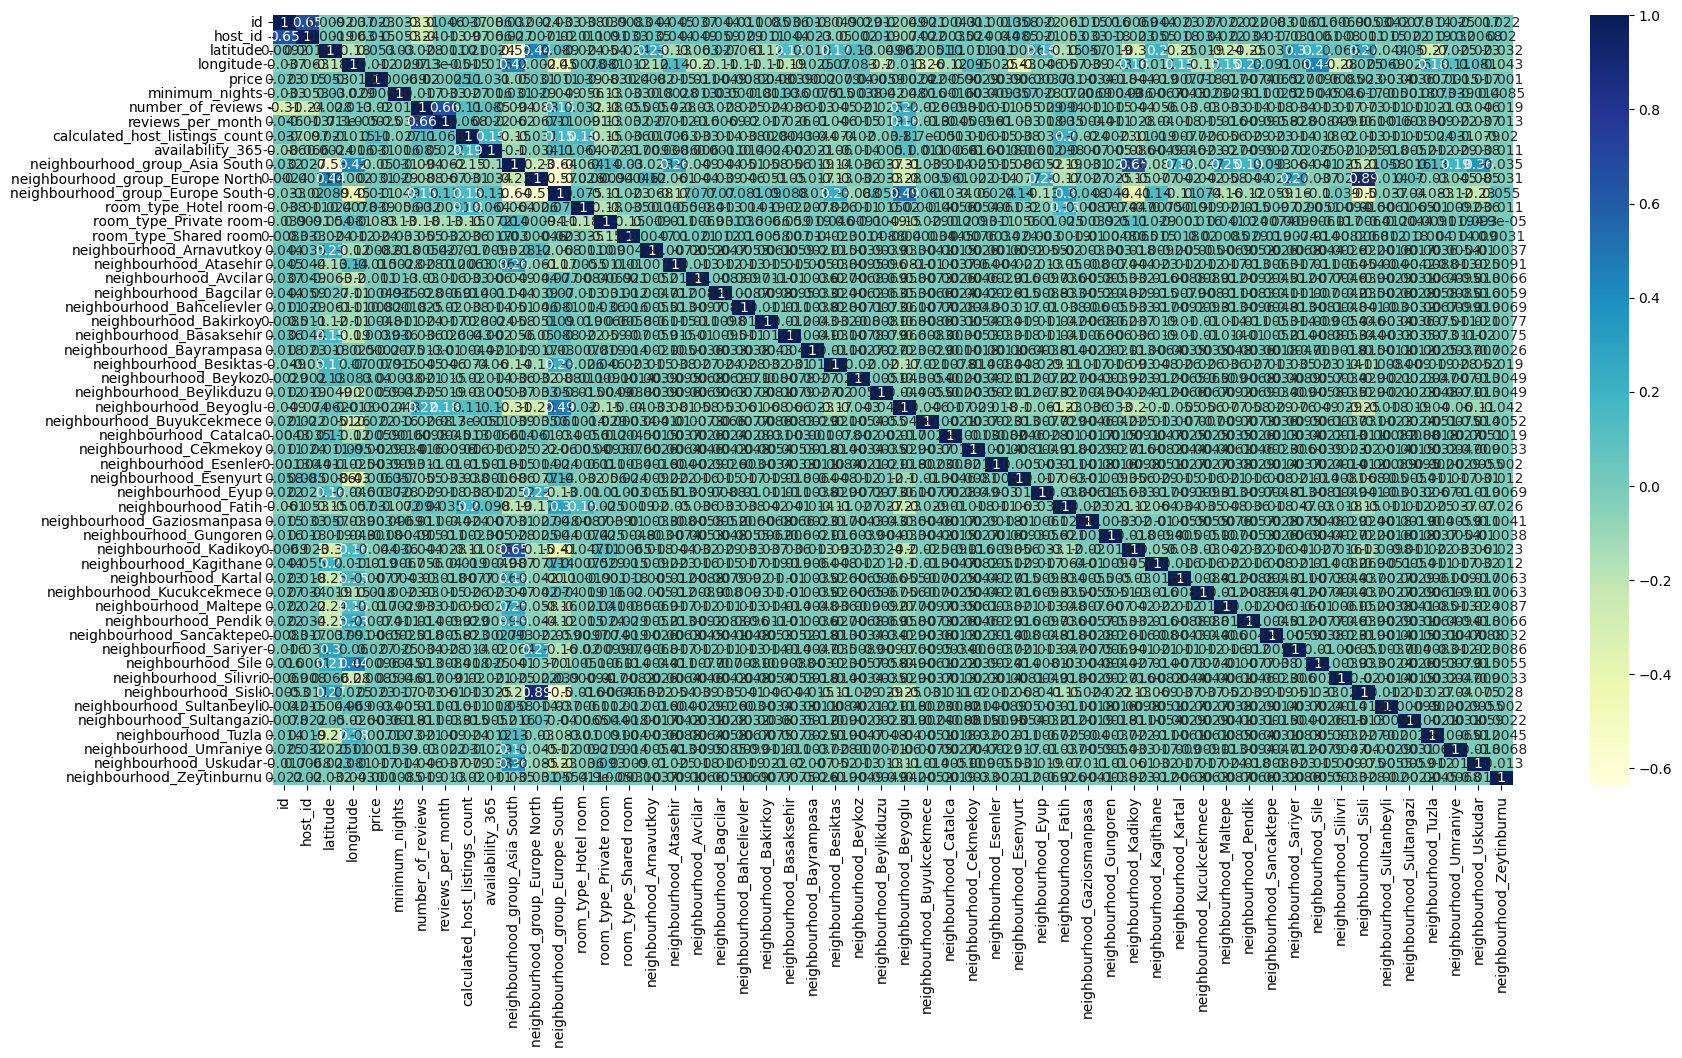

In [31]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr() , annot = True , cmap = "YlGnBu")

In [32]:
cor_matrix = df.corr().abs()

In [33]:
upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

In [34]:
drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col]>0.90) ]

In [35]:
drop_list

[]

In [36]:
x= df.drop(['price'] , axis = 1).values
y= df['price'].values

In [37]:
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size= 0.25 , random_state= 42)

In [38]:
x_train.shape

(17793, 53)

In [39]:
x_test.shape

(5932, 53)

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
ss=StandardScaler()
x_train =ss.fit_transform(x_train )
x_test=ss.transform(x_test)

In [42]:
from sklearn.ensemble import RandomForestRegressor
random_forest=RandomForestRegressor()
random_forest.fit(x_train , y_train)
print("Random Forest Training Accuracy:", random_forest.score(x_train , y_train))
print("Random Forest Testing Accuracy:", random_forest.score(x_test , y_test))

Random Forest Training Accuracy: 0.9248675532374699
Random Forest Testing Accuracy: 0.18428592769784058


In [43]:
y_pred = random_forest.predict(x_test)
y_pred

y_pred = random_forest.predict(x_test)
df3 = pd.DataFrame({"Y_test": y_test , "Y_pred" : y_pred})
df3.head(20)

,Y_test,Y_pred
0,617,1083.65
1,377,548.92
2,453,741.74
3,103,437.74
4,82,135.53
5,62,228.24
6,425,629.29
7,761,2005.76
8,350,15920.28
9,398,519.55


In [44]:
from sklearn.metrics import r2_score

In [45]:
reg_score = r2_score(y_test, y_pred)
reg_score

0.18428592769784058